In [1]:
!pip install gpflow --upgrade #tensorflow~=2.12.0 tensorflow-probability~=0.20.0

In [1]:
import gpflow
from gpflow.ci_utils import reduce_in_tests
from gpflow.utilities import print_summary, set_trainable
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd


# Seed para que las redes con iguales parametros no generen resultados aleatorios y tener repetibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Para las graficas importamos matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Función para plotear
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

#Función Rounded Accuracy
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

    
#Traemos los datos de Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full_normalized = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full_normalized[:-5000], X_train_full_normalized[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#Función para ver los resultados de las reconstrucciones
def show_reconstructions(model, images=X_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ERROR: Could not find a version that satisfies the requirement multiclass_classification (from versions: none)
ERROR: No matching distribution found for multiclass_classification


In [13]:
from gpflow import multiclass_classification

ImportError: cannot import name 'multiclass_classification' from 'gpflow' (/opt/conda/lib/python3.10/site-packages/gpflow/__init__.py)

In [2]:
print(tf.__version__)
print(gpflow.__version__)

2.16.1
2.9.2


In [3]:
print(X_train.shape)
X_test_f = X_test.reshape(-1,28*28)
print(X_test_f.shape)
y_test=y_test.reshape(-1,1)
print(y_test.shape)
X_test = X_test_f.astype(np.float64)
y_test = y_test.astype(np.float64)
data=(X_test,y_test)

(55000, 28, 28)
(10000, 784)
(10000, 1)


In [5]:
# sum kernel: Matern32 + White
kernel = gpflow.kernels.Matern32() + gpflow.kernels.White(variance=0.01)

C = 10
# Robustmax Multiclass Likelihood
invlink = gpflow.likelihoods.RobustMax(C)  # Robustmax inverse link function
likelihood = gpflow.likelihoods.MultiClass(
    C, invlink=invlink
)  # Multiclass likelihood
Z = X_test[::5].copy()  # inducing inputs

m = gpflow.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=Z,
    num_latent_gps=C,
    whiten=True,
    q_diag=True,
)

# Only train the variational parameters
set_trainable(m.kernel.kernels[1].variance, False)
set_trainable(m.inducing_variable, False)
print_summary(m, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.009999999999999998
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(2000, 784)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,Identity,,True,"(2000, 10)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,Softplus,,True,"(2000, 10)",float64,"[[1., 1., 1...."


In [7]:
for var in m.trainable_variables:
    print(var.dtype)
print(tf.shape(Z))

<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
tf.Tensor([2000  784], shape=(2,), dtype=int32)


In [8]:
opt = gpflow.optimizers.Scipy()

opt_logs = opt.minimize(
    m.training_loss_closure(data),
    m.trainable_variables,
    options=dict(maxiter=reduce_in_tests(1000)),
)
print_summary(m, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,52.22044
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,50.32165
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.009999999999999998
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(2000, 784)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,Identity,,True,"(2000, 10)",float64,"[[-4.47115170e-01, -6.28983084e-01, -1.55609410e-01..."
SVGP.q_sqrt,Parameter,Softplus,,True,"(2000, 10)",float64,"[[0.00424646, 0.00926747, 0.00357182..."


In [9]:
plot_posterior_predictions(m, X_test, y_test)

NameError: name 'plot_posterior_predictions' is not defined

### Predicción con GPflow

- Después de entrenar el modelo, se pueden realizar predicciones para nuevos datos utilizando el modelo ajustado.
- GPflow proporciona métodos para obtener tanto la media predictiva como la varianza, lo cual es útil para estimar la incertidumbre en las predicciones.



In [13]:
# Nuevos datos para predicción
Xnew = np.linspace(0, 1, 100).reshape(-1, 1)

# Predicción usando el modelo GPR
f_mean, f_var = model.predict_f(Xnew, full_cov=False)
y_mean, y_var = model.predict_y(Xnew)

### Graficar predictiva

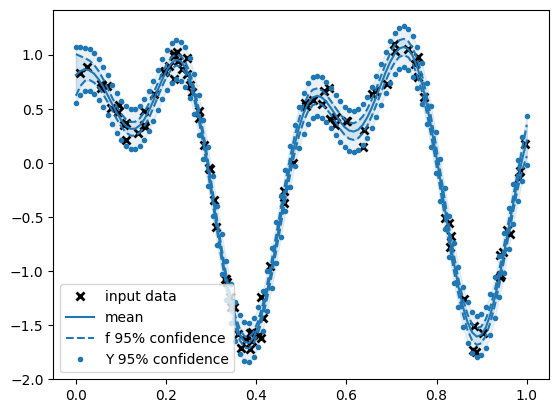

In [14]:
import matplotlib.pyplot as plt

f_lower = f_mean - 1.96 * np.sqrt(f_var)
f_upper = f_mean + 1.96 * np.sqrt(f_var)
y_lower = y_mean - 1.96 * np.sqrt(y_var)
y_upper = y_mean + 1.96 * np.sqrt(y_var)

plt.plot(X, Y, "kx", mew=2, label="input data")
plt.plot(Xnew, f_mean, "-", color="C0", label="mean")
plt.plot(Xnew, f_lower, "--", color="C0", label="f 95% confidence")
plt.plot(Xnew, f_upper, "--", color="C0")
plt.fill_between(
    Xnew[:, 0], f_lower[:, 0], f_upper[:, 0], color="C0", alpha=0.1
)
plt.plot(Xnew, y_lower, ".", color="C0", label="Y 95% confidence")
plt.plot(Xnew, y_upper, ".", color="C0")
plt.fill_between(
    Xnew[:, 0], y_lower[:, 0], y_upper[:, 0], color="C0", alpha=0.1
)
plt.legend()

In [15]:
print('kernel hyperparameter trained\n',model.kernel.lengthscales)

kernel hyperparameter trained
 <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.09238610743382406>



### Ventajas y Desventajas del GPR con GPflow

Ventajas:

  - Predicciones probabilísticas: GPflow facilita la obtención de predicciones probabilísticas con incertidumbres, lo que es útil para evaluar la confiabilidad de las predicciones.
  - Flexibilidad y eficiencia: La integración con TensorFlow permite aprovechar técnicas de optimización avanzadas y hardware acelerado, como GPUs.
  - Fácil de usar: GPflow tiene una API amigable que simplifica la creación y entrenamiento de modelos de procesos Gaussianos.


Desventajas:

- Escalabilidad limitada: A pesar de las optimizaciones, los modelos de GPR siguen siendo computacionalmente costosos para grandes conjuntos de datos debido a la inversión de matrices.
- Ajuste de hiperparámetros: La selección del kernel adecuado y el ajuste de hiperparámetros son cruciales y pueden requerir experiencia y ajuste manual.


## Ejercicio

- Describa el modelo y la optimización de los GPR, GPC, VGP, SGPR, y SVGP.

- Discuta los métodos de optimización que utiliza GPFlow con scipy y TensorFlow.

- Implemente un clasificador multiclase, para la base de datos fashionMnist, utilizando un Sparse GP implementado con GPflow y optimizador de TensorFlow. (ver [https://gpflow.github.io/GPflow/develop/getting_started.html](https://gpflow.github.io/GPflow/develop/getting_started.html))

- Discuta las ventajas y desventajas de un clasificador tipo autoencoder variacional vs un modelo basado en GP y GPflow.